In [187]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = ['val2017.zip', 'annotations_trainval2017.zip']

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip
Finished downloading val2017.zip . Starting to unzip.
Finished unzipping val2017.zip
Done transferring all datasets


In [0]:
import torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_eval_output = model.eval()

In [0]:
import json
instances_val2017_json = json.load(open('annotations/instances_val2017.json'))

In [190]:
person_id = [category['id'] for category in instances_val2017_json['categories'] if category['name']=='person'][0]
print('person_id='+str(person_id)+'\n')
category_names_by_id = dict((category['id'],category['name']) for category in instances_val2017_json['categories'])

person_id=1



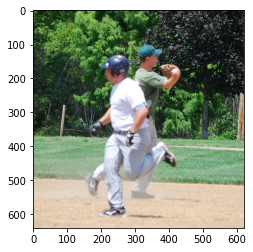

In [191]:
import cv2, matplotlib.pyplot as plt
import PIL.Image, numpy
image1_path = '/content/val2017/000000000139.jpg'
image2_path = '/content/val2017/000000000872.jpg'
image3_path = '/content/val2017/000000000885.jpg'
image_pil = PIL.Image.open(image2_path)
image_np=numpy.array(image_pil)
#image_np = cv2.imread(image3_path)
#image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
image = torch.from_numpy(image_np)
#plt.imshow(image_np)
plt.imshow(image)

In [192]:
import torch
image_processed = image.permute((2,0,1))
image_processed = image_processed*(1/255.0)
result = model([image_processed])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


result1.keys()=dict_keys(['boxes', 'labels', 'scores'])
person_object_indices=[0, 1]

label=person, score=0.9990866184234619

label=person, score=0.9888269901275635



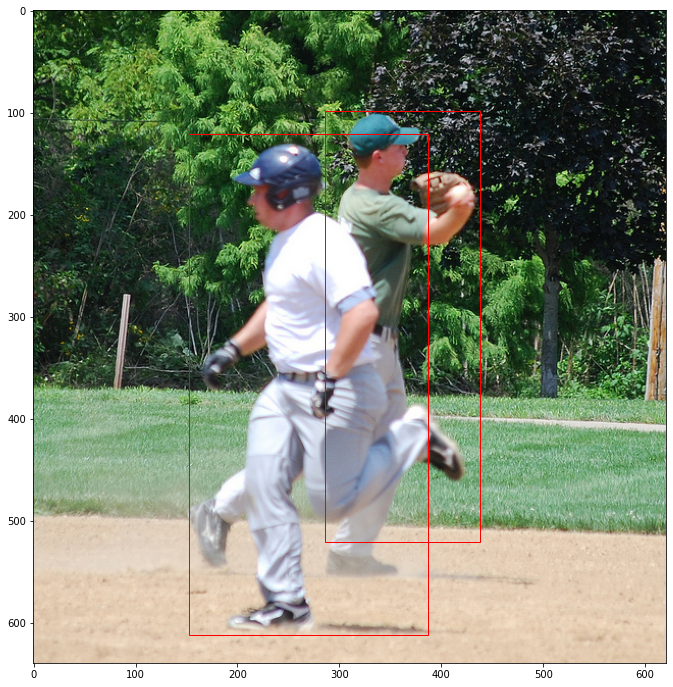

In [193]:
result1 = result[0]
threshold = 0.9
print('result1.keys()='+str(result1.keys()))
object_labels = result1['labels']
object_scores = [float(score) for score in result1['scores']]
n_objects = len(object_labels)
person_object_indices = [i for i in range(n_objects) if int(object_labels[i]) == person_id and object_scores[i]>threshold]
print('person_object_indices='+str(person_object_indices)+'\n')
plt.figure(figsize=(12,12))
figure = plt.imshow(image)

for object_index in person_object_indices:
  box = result1['boxes'][object_index]
  label = category_names_by_id[int(result1['labels'][object_index])]
  score = float(result1['scores'][object_index])
  print('label=' + str(label) + ', score=' + str(score) + '\n')
  x1,y1,x2,y2 = box
  x,y = x1,y1
  width, height = (x2-x1),(y2-y1)
  figure.axes.add_patch(plt.Rectangle((x,y),width,height,fill=False,color='Red'))

score=0.9990866184234619

score=0.9888269901275635



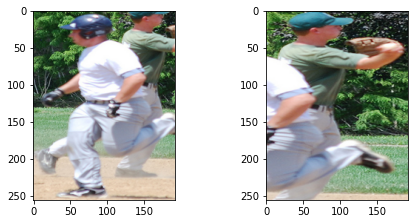

In [194]:
def crop_and_resize_image(image, crop, new_size):
  new_width, new_height = new_size
  crop_x, crop_y, crop_width, crop_height = crop
  image=image.crop((crop_x,crop_y,crop_x+crop_width,crop_y+crop_height))
  image=image.resize((new_width,new_height))
  return image

figure = plt.figure(figsize=(16,16))

for object_num in range(len(person_object_indices)):
  object_index = person_object_indices[object_num]
  box = result1['boxes'][object_index]
  x1,y1,x2,y2 = map(float,box)
  print('score='+str(object_scores[object_index])+'\n')
  cropped_image = crop_and_resize_image(image_pil, (x1,y1,(x2-x1),(y2-y1)), (192, 256))
  figure.add_subplot(4,4, 1+object_num)
  plt.imshow(cropped_image)